In [2]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from datetime import datetime

from scipy.optimize import curve_fit

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [3]:
def get_pulse_area(tt, dd):
    # Time in s, drive signal in V
    noise = np.mean(dd[tt < -0.5e-7])
    area = np.trapz(dd-noise, x=tt)
    
    return area

def process_pulse_waveforms(files):
    tt = None
    dds, aas = [], []
    for file in files:
        data = np.genfromtxt(file, delimiter=',', skip_header=1)
        _tt, _dd = data.T[0], data.T[1]
        _aa = get_pulse_area(_tt, _dd)

        if tt is None:
            tt = _tt

        dds.append(_dd)
        aas.append([_aa])

    return tt, dds, aas

In [4]:
from scipy.special import erf

def gaus(x, x0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - x0)**2 / (2 * sigma**2))

def search_expectation(x0, alpha, amp2kev, sig_amp):
    sigma = sig_amp * amp2kev
    bias = alpha * sigma

    first = bias * 0.5 * ( erf((bias - x0)/(np.sqrt(2) * sigma)) - erf((-1 * bias - x0)/(np.sqrt(2) * sigma)) )

    xx0 = np.linspace(bias, x0 + 5*sigma, 1000)
    second = np.trapz(gaus(xx0, x0, sigma) * np.abs(xx0), xx0, axis=0)

    xx1 = np.linspace(x0 - 5*sigma, -1 * bias, 1000)
    third = np.trapz(gaus(xx1, x0, sigma) * np.abs(xx1), xx1, axis=0)

    return (first + second + third) / amp2kev

In [10]:
folder = r'/Volumes/LaCie/pulse_waveform/20241204_quantum_composers'

tt = None
dds_mean, dds_std, aas_mean, aas_std = [], [], [], []

for dataset in ['2_5v', '5v', '7_5v', '10v', '12_5v', '15v', '17_5v', '20v']:
    files = glob.glob(os.path.join(folder, f'{dataset}/C3_*.CSV'))
    _tt, dds, aas = process_pulse_waveforms(files)
    
    mean = np.mean(dds, axis=0)
    std = np.std(dds, axis=0)

    aa_mean = np.mean(aas)
    aa_std  = np.std(aas)

    if tt is None:
        tt = _tt

    dds_mean.append(mean)
    aas_mean.append(aa_mean)
    dds_std.append(std)
    aas_std.append(aa_std)

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1828/2056199697.py:14: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1828/2056199697.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)


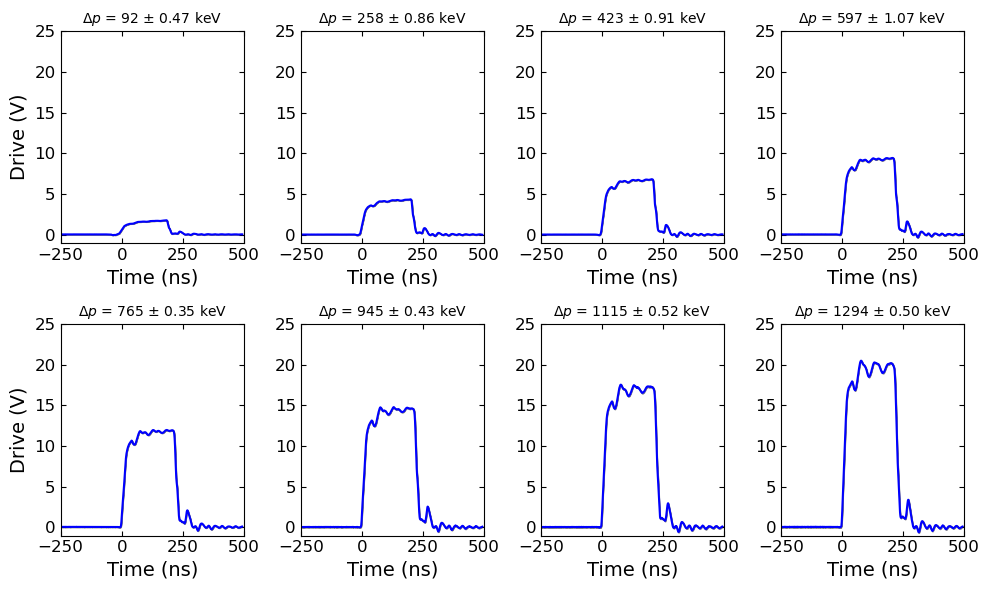

In [11]:
charge = 8
efield = 128 # V/m

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i in range(8):
    ax = axes.flatten()[i]

    amp_kev = charge * aas_mean[i] * 128 * 1.602e-19 * utils.SI2ev / 1000
    amp_kev_std = charge * aas_std[i] * 128 * 1.602e-19 * utils.SI2ev / 1000
    
    ax.fill_between(tt*1e9, dds_mean[i]-dds_std[i], dds_mean[i]+dds_std[i], color='grey', alpha=0.95)
    ax.plot(tt*1e9, dds_mean[i], color='blue')
    
    ax.set_title(f'$\Delta p$ = {int(amp_kev)} $\pm$ {amp_kev_std:.2f} keV', fontsize=10)

    ax.set_xlim(-250, 500)
    ax.set_ylim(-1, 25)
    
    if i == 0 or i == 4:
        ax.set_ylabel('Drive (V)')

    ax.set_xlabel('Time (ns)')

fig.tight_layout()

## Combined dataset (two new datasets `202501017*` are later added)

In [84]:
sphere = 'sphere_20250103'
data_folder = ['20250106_8e_alignment0_2e-8mbar_0', '20250106_8e_alignment0_2e-8mbar_1', '20250107_8e_alignment0_1e-8mbar_0', '20250107_8e_alignment0_1e-8mbar_1', 
               '20250108_8e_alignment0_1e-8mbar_0', '20250108_8e_alignment0_1e-8mbar_1', '20250109_8e_alignment1_1e-8mbar_0', '20250109_8e_alignment1_1e-8mbar_1']
dataset_prefixs = ['20250116_dg_8e_200ns_', '20250116_dg_8e_200ns_', '20250107_dg_8e_200ns_', '20250107_dg_8e_200ns_', 
                   '20250108_dg_8e_200ns_', '20250108_dg_8e_200ns_', '20250109_dg_8e_200ns_', '20250109_dg_8e_200ns_']
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]
unnormalized_amps_all = [[] for i in range(len(voltages))]

for i, v in enumerate(voltages):
    for j, f in enumerate(data_folder):
        folder = f'/Volumes/LaCie/pulse_calibration/{sphere}/{f}'
        dataset = dataset_prefixs[j] + f'{v}v'

        combined_path = os.path.join(folder, f'{dataset}*.hdf5')
        data_files = glob.glob(combined_path)
        print(combined_path)

        unnormalized_amps_all[i].append(utils.get_unnormalized_amps(data_files, noise=False))

/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar_0/20250116_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar_1/20250116_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250107_8e_alignment0_1e-8mbar_0/20250107_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250107_8e_alignment0_1e-8mbar_1/20250107_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250108_8e_alignment0_1e-8mbar_0/20250108_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250108_8e_alignment0_1e-8mbar_1/20250108_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250109_8e_alignment1_1e-8mbar_0/20250109_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250109_8e_alignment1_1e-8mbar_1/20250109_dg_8e_200ns_2.5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar

In [210]:
# Perform the same search on noise only data
data_folder = ['20250106_8e_alignment0_2e-8mbar_0', '20250106_8e_alignment0_2e-8mbar_1', '20250107_8e_alignment0_1e-8mbar_0', '20250107_8e_alignment0_1e-8mbar_1', 
               '20250108_8e_alignment0_1e-8mbar_0', '20250108_8e_alignment0_1e-8mbar_1', '20250117_8e_alignment1_8e-9mbar_0', '20250117_8e_alignment1_8e-9mbar_1']

datasets = ['20250116_dg_8e_200ns_5v', '20250116_dg_8e_200ns_5v', '20250107_dg_8e_200ns_5v', '20250107_dg_8e_200ns_5v', 
            '20250108_dg_8e_200ns_5v', '20250108_dg_8e_200ns_5v', '20250117_dg_8e_200ns_5v', '20250117_dg_8e_200ns_5v']

unnormalized_amps_noise = []
for i, f in enumerate(data_folder):
    folder = f'/Volumes/LaCie/pulse_calibration/{sphere}/{f}'
    dataset = datasets[i]

    combined_path = os.path.join(folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)
    print(combined_path)

    unnormalized_amps_noise.append(utils.get_unnormalized_amps(data_files, True))

/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar_0/20250116_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar_1/20250116_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250107_8e_alignment0_1e-8mbar_0/20250107_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250107_8e_alignment0_1e-8mbar_1/20250107_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250108_8e_alignment0_1e-8mbar_0/20250108_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250108_8e_alignment0_1e-8mbar_1/20250108_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250117_8e_alignment1_8e-9mbar_0/20250117_dg_8e_200ns_5v*.hdf5
/Volumes/LaCie/pulse_calibration/sphere_20250103/20250117_8e_alignment1_8e-9mbar_1/20250117_dg_8e_200ns_5v*.hdf5


#### Two datasets (`20250109_*`) has unusually small amplitudes. It is likely that the charge is off - it might be 7e instead of 8e. Exclude from analysis for now.

In [ ]:
unnormalized_amps_all_flattened = []
for i in range(len(voltages)):
    tmp = []
    for j, _unnormalized_amps in enumerate(unnormalized_amps_all[i]):
        if j == 6 or j == 7:
            continue
        for a in _unnormalized_amps:
            tmp.append(a)
    unnormalized_amps_all_flattened.append(np.asarray(tmp))


## Read in the processed calibration data

In [12]:
outfile_name = 'sphere_20250103_calibration_all.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['calibration_data_processed']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

In [13]:
bins = np.arange(0, 2500, 50) / 7400
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)

# unnormalized_amps_noise_flattened = np.asarray([a for amps in unnormalized_amps_noise for a in amps])
# unnormalized_amps_noise_flattened = np.asarray([a for amps in unnormalized_amps_noise[:-2] for a in amps])
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Averaged `amp2keV`: 7396.062147743912


<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1828/426602718.py:22: S

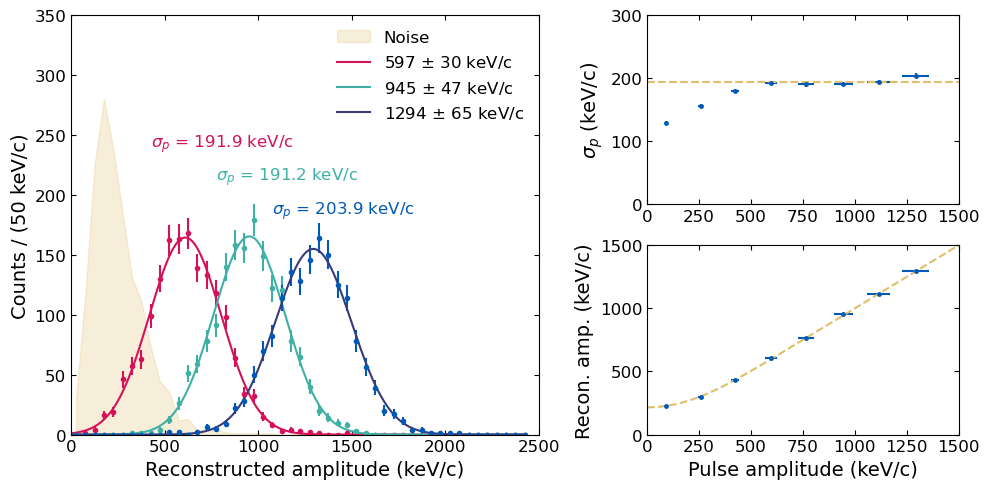

In [20]:
from matplotlib.gridspec import GridSpec

xx = np.linspace(0, 1500, 500)
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05
n_pulses = np.asarray([amps.size for amps in unnormalized_amps_all_flattened])

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[3])

# First plot
ax = ax0
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 / gps[7][1]

ax.fill_between(bcs[0]*amp2kev_all, hh_noise, color='#E1BE6A', alpha=0.25, label='Noise')

ax.errorbar(bcs[0]*amp2kev_all, hhs[3], yerr=np.sqrt(hhs[3]), fmt='.', color='#D41159')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[3]), label=f'597 $\pm$ {597*0.05:.0f} keV/c', color='#D41159')

ax.errorbar(bcs[0]*amp2kev_all, hhs[5], yerr=np.sqrt(hhs[5]), fmt='.', color='#40B0A6')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[5]), label=f'945 $\pm$ {945*0.05:.0f} keV/c', color='#40B0A6')

ax.errorbar(bcs[0]*amp2kev_all, hhs[7], yerr=np.sqrt(hhs[7]), fmt='.', color='#005AB5')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=f'1294 $\pm$ {1294*0.05:.0f} keV/c')

ax.text(1075, 115*8/5, f'$\sigma_p$ = {gps[7][2]*amp2kev_all:.1f} keV/c', color='#005AB5', fontsize=12)
ax.text(775, 132.5*8/5, f'$\sigma_p$ = {gps[5][2]*amp2kev_all:.1f} keV/c', color='#40B0A6', fontsize=12)
ax.text(425, 150*8/5, f'$\sigma_p$ = {gps[3][2]*amp2kev_all:.1f} keV/c', color='#D41159', fontsize=12)

ax.legend(frameon=False, fontsize=12)
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel(f'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)
ax.set_ylim(0, 350)

# Second plot fo resolution
ax = ax1

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
ax.errorbar(pulseamps, sig_p_avg, yerr=sig_p_avg/np.sqrt(2 * (n_pulses-1)), xerr=pulseamps_err, 
            fmt='.', markersize=5, color='#005AB5')

idx_fit = pulseamps > 500
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
xx = np.linspace(0, 4000, 500)
ax.plot(xx, np.full_like(xx, popt_sig[0]), '--', color='#E1BE6A')

ax.set_ylim(0, 300)
ax.set_xlim(0, 1500)
# ax.set_xlabel('Pulse amplitude (keV/c)')
ax.set_ylabel('$\sigma_p$ (keV/c)')


# Third plot for search bias
ax = ax2
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

# Fit for search bias
f_bias = lambda x, alpha: search_expectation(x, alpha, amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all
popt_bias, pcov_bias = curve_fit(f_bias, pulseamps, amps*amp2kev_all, p0=[0.87], sigma=sig_p_avg/np.sqrt(n_pulses))

ax.errorbar(pulseamps, amps*amp2kev_all, yerr=amps_std*amp2kev_all/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color='#005AB5')
ax.plot(xx, f_bias(xx, *popt_bias), '--', color='#E1BE6A', 
             label=f'$\sigma_{{p, 0}}$={popt_sig[-1]:.0f} keV/c\n$\sigma_b$ = {popt_sig[-1]*popt_bias[-1]:.0f} keV/c')

ax.set_ylim(0, 1500)
ax.set_xlim(0, 1500)
ax.set_xlabel('Pulse amplitude (keV/c)')
ax.set_ylabel('Recon. amp. (keV/c)')

fig.tight_layout()

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/impulse_calibration_sphere_20250103.pdf', dpi=600)

print(f'Averaged `amp2keV`: {amp2kev_all}')

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1828/1280054732.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=f'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/c', color=colors[i])


Text(0, 0.5, 'Counts / (50 keV/c)')

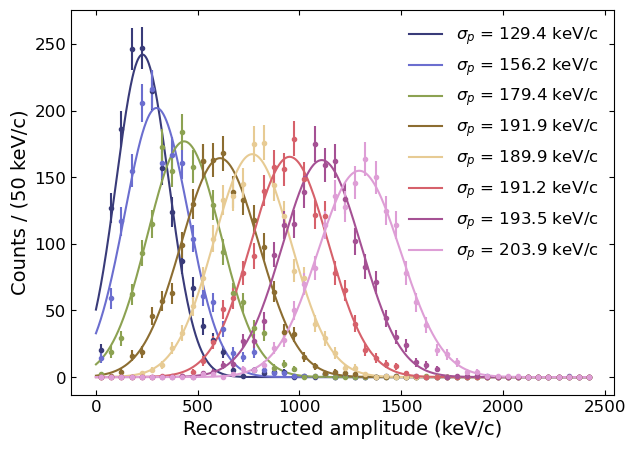

In [15]:
colors = plt.colormaps.get_cmap('tab20b').resampled(8).colors

fig, ax = plt.subplots(figsize=(7, 5))

xx = np.linspace(0, np.max(bcs[0]), 1000)
for i in range(8):
    ax.errorbar(bcs[0]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=f'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/c', color=colors[i])

ax.legend(frameon=False)
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel(f'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

## Derive the efficiency curve from the combined dataset

In [16]:
def gaus_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def func_fit_eff(x, a, b):
    sig_fit = a * x + b
    
    xvec = np.linspace(5 * sig_fit, 10000, 500)
    ret = np.trapz(gaus_pdf(xvec, x, sig_fit), x=xvec, axis=0)

    return ret

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

In [17]:
def get_detection_efficiency(normalized_amps, sigmas, threshold=5):
    eff, eff_err = [], []
    for i, amps in enumerate(normalized_amps):
        count = np.count_nonzero(amps > threshold * sigmas[i])
        eff.append(count / amps.size)
        eff_err.append(np.sqrt(count) / amps.size)

    return eff, eff_err

def func(x, a, b, z, f):
    return a * erf((x - z) * f) + b

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def func3(x, z, a, b):
    return 0.5 * erf((x - z) * (a * x + b)) + 0.5

In [18]:
normalized_amps_all = [a * amp2kev_all for a in unnormalized_amps_all_flattened]

sig_p_fit = popt_sig[0]
eff, eff_err = get_detection_efficiency(normalized_amps_all, np.full(8, sig_p_fit), 5)
popt, pcov = curve_fit(func2, pulseamps, eff, p0=[850, 0.001], sigma=eff_err, maxfev=5000)

[0.00440251572327044, 0.00630119722747322, 0.0043997485857950975, 0.03474415666456096, 0.142049025769956, 0.4628463476070529, 0.7719298245614035, 0.9382871536523929]


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1828/1812528902.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.text(60, 0.77, f'$\sigma_p$ = {sig_p_fit:.1f} keV/c', fontsize=12)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1828/1812528902.py:15: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('5-$\sigma_p$ signal efficiency')


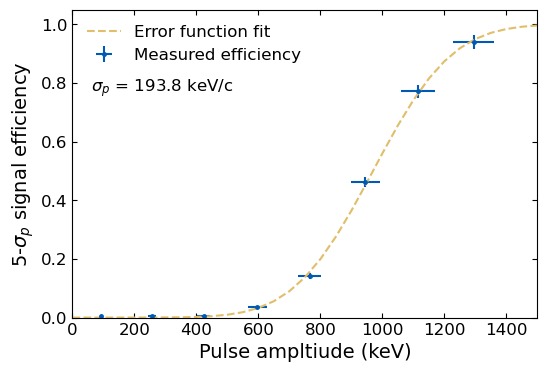

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

xx = np.arange(0, 10000, 50)
f = np.interp(xx, pulseamps, eff)

ax.errorbar(pulseamps, eff, yerr=eff_err, xerr=pulseamps_err, fmt='.', markersize=5, label='Measured efficiency', color='#005AB5')
ax.plot(xx, func2(xx, *popt), '--',label='Error function fit', color='#E1BE6A')

ax.text(60, 0.77, f'$\sigma_p$ = {sig_p_fit:.1f} keV/c', fontsize=12)

ax.legend(frameon=False)
ax.set_xlim(0, 1500)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Pulse ampltiude (keV)')
ax.set_ylabel('5-$\sigma_p$ signal efficiency')

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/signal_efficiency_sphere_20250103.pdf', dpi=600)

print(eff)
# print(popt)

(0.0, 4000.0)

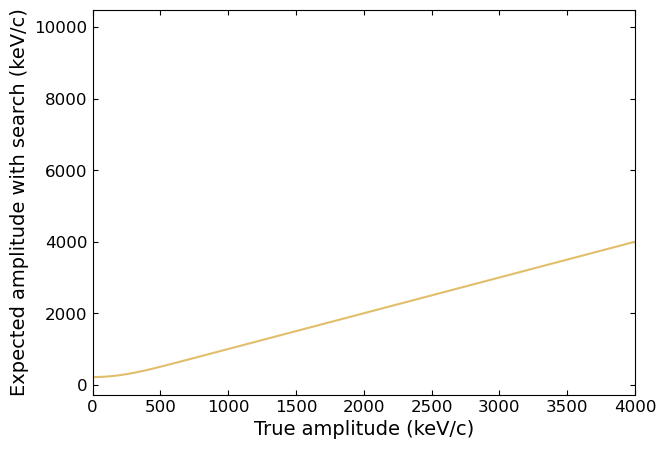

In [28]:
amp_true = np.linspace(0, 10000, 10000)
search_expt_amp_true = search_expectation(amp_true, popt_bias[-1], amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all

plt.plot(amp_true, search_expt_amp_true, color='#E1BE6A')
plt.xlabel('True amplitude (keV/c)')
plt.ylabel('Expected amplitude with search (keV/c)')

plt.xlim(0, 4000)

In [29]:
outfile_name = 'sphere_20250103_calibration_all.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('calibration_data_processed')
    g.attrs['amp2kev'] = amp2kev_all
    g.attrs['sigma_p_kev'] = popt_sig[-1]
    g.attrs['search_bias_kev'] = popt_bias[-1] * popt_sig[-1]
    
    for i, v in enumerate(voltages):
        g.create_dataset(f'unnormalized_amps_{str(v)}v', data=unnormalized_amps_all_flattened[i], dtype=np.float64)
        g.create_dataset(f'histogram_{str(v)}v', data=hhs[i], dtype=np.int16)
        g.create_dataset(f'gp_{str(v)}v', data=gps[i], dtype=np.float64)
        if i == 0:
            g.create_dataset(f'bc', data=bcs[i], dtype=np.float64)

    g.create_dataset(f'unnormalized_amps_noise_5v', data=unnormalized_amps_noise_flattened, dtype=np.float64)
    g.create_dataset(f'histogram_noise_5v', data=hh_noise, dtype=np.int16)

    g.create_dataset(f'sig_efficiency_fit_params', data=popt, dtype=np.float64)

    g.create_dataset('amp_true', data=amp_true, dtype=np.float64)
    g.create_dataset('amp_search', data=search_expt_amp_true, dtype=np.float64)

    fout.close()

In [29]:
popt_bias * popt_sig[-1]

array([178.16989205])

In [187]:
folder = r'/Volumes/LaCie/pulse_calibration/sphere_20250103/20250117_8e_alignment1_8e-9mbar_1'
datasets = [f'20250117_dg_8e_200ns_{v}v' for v in ['2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']]
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps_1 = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20250117_dg_8e_200ns_2.5v
20250117_dg_8e_200ns_5v
20250117_dg_8e_200ns_7.5v
20250117_dg_8e_200ns_10v
20250117_dg_8e_200ns_12.5v
20250117_dg_8e_200ns_15v
20250117_dg_8e_200ns_17.5v
20250117_dg_8e_200ns_20v


(0.0, 2500.0)

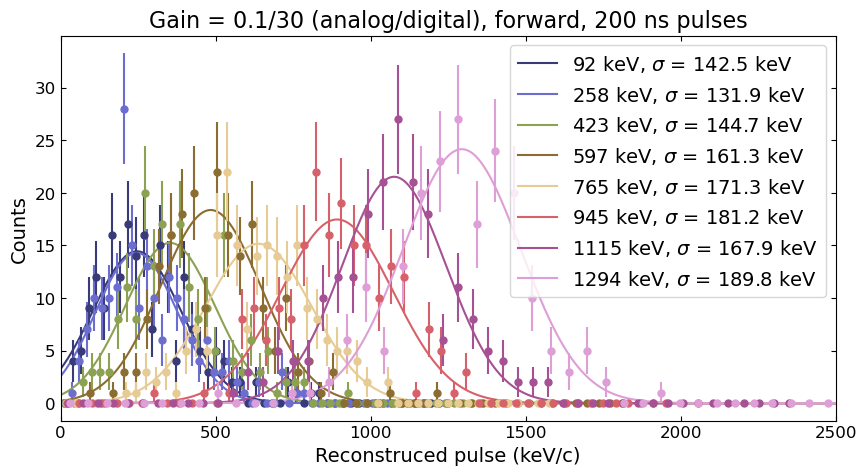

In [188]:
unnormalized_amps_1 = [amps[~np.isnan(amps)] for amps in unnormalized_amps_1]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_1)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps_1]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [169]:
folder = r'/Volumes/LaCie/pulse_calibration/sphere_20250103/20250117_8e_alignment1_8e-9mbar_0'
datasets = [f'20250117_dg_8e_200ns_{v}v' for v in ['2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']]
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20250117_dg_8e_200ns_2.5v
20250117_dg_8e_200ns_5v
20250117_dg_8e_200ns_7.5v
20250117_dg_8e_200ns_10v
20250117_dg_8e_200ns_12.5v
20250117_dg_8e_200ns_15v
20250117_dg_8e_200ns_17.5v
20250117_dg_8e_200ns_20v


(0.0, 2500.0)

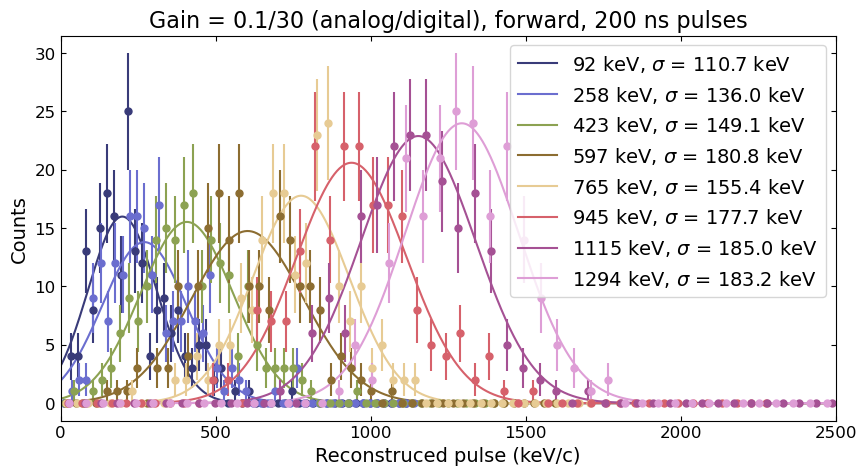

In [170]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [8]:
folder = r'/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar_0'
datasets = [f'20250116_dg_8e_200ns_{v}v' for v in ['2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']]  # there is a typo in file names...fix later
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20250116_dg_8e_200ns_2.5v
20250116_dg_8e_200ns_5v
20250116_dg_8e_200ns_7.5v
20250116_dg_8e_200ns_10v
20250116_dg_8e_200ns_12.5v
20250116_dg_8e_200ns_15v
20250116_dg_8e_200ns_17.5v
20250116_dg_8e_200ns_20v


(0.0, 2500.0)

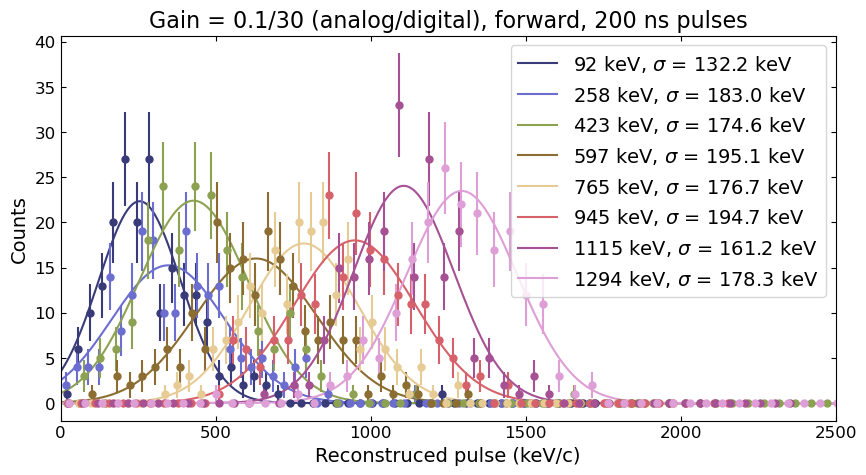

In [9]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [10]:
folder = r'/Volumes/LaCie/pulse_calibration/sphere_20250103/20250106_8e_alignment0_2e-8mbar_1'
datasets = [f'20250116_dg_8e_200ns_{v}v' for v in ['2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']]  # there is a typo in file names...fix later
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05

unnormalized_amps = utils.get_all_unnormalized_amps(folder, datasets, pulseamps, False)

20250116_dg_8e_200ns_2.5v
20250116_dg_8e_200ns_5v
20250116_dg_8e_200ns_7.5v
20250116_dg_8e_200ns_10v
20250116_dg_8e_200ns_12.5v
20250116_dg_8e_200ns_15v
20250116_dg_8e_200ns_17.5v
20250116_dg_8e_200ns_20v


(0.0, 2500.0)

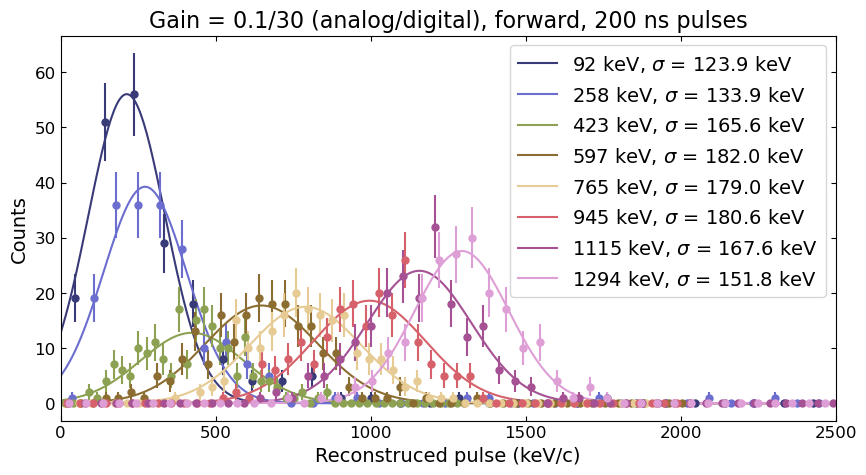

In [11]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]
hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps)

amp2kevs = [(pulseamps[i] / gps[i][1]) for i in range(len(pulseamps))]
amp2kev = np.mean(np.asarray(amp2kevs[-1:]))

normalized_amps = [amp * amp2kev for amp in unnormalized_amps]
n_pulses = np.asarray([amps.size for amps in normalized_amps])

fig, ax = utils.plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, amp2kev=amp2kev, title='Gain = 0.1/30 (analog/digital), forward, 200 ns pulses')
ax.set_xlim(0, 2500)

In [17]:
amp2kevs

[2891.0595363894513,
 6343.037452411046,
 6683.791979618835,
 6166.821440278299,
 6485.028675523439,
 6349.330460455417,
 6450.238889379387,
 6693.706148709035]